In [47]:
import numpy as np
import pandas as pd
from scipy import spatial
import random
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA

In [3]:
image_locs = pd.read_csv('geo_image_locations.csv')
image_locs.head()

,location,label
0,../geological_similarity\andesite\012L6.jpg,0
1,../geological_similarity\andesite\01ITR.jpg,0
2,../geological_similarity\andesite\01LQQ.jpg,0
3,../geological_similarity\andesite\0230P.jpg,0
4,../geological_similarity\andesite\02741.jpg,0


In [4]:
embeddings = np.load("geo_siamese_embeds.npy")
embeddings.shape

(29998, 50)

In [5]:
embeddings[0]

array([  904.29456  ,   131.86935  ,    -6.560202 ,    -1.8538573,
          40.24828  ,   551.6593   ,   500.05997  ,   150.38301  ,
        -514.0599   ,   281.09772  ,   826.24896  ,   256.21228  ,
         219.105    ,  -288.60437  ,   585.09357  ,  -126.90682  ,
         255.22958  ,   -40.375412 ,   143.65877  ,   119.090416 ,
        -184.0937   ,    59.40103  ,    30.300495 ,   427.7617   ,
         122.07479  ,  -266.16373  ,   -45.379    ,   686.51465  ,
         238.9694   ,   188.52693  ,   322.23862  ,  -109.87884  ,
          10.448791 ,   343.5501   ,   727.57196  ,   569.9228   ,
        -346.09323  ,   407.59903  ,  -282.3198   , -1009.6946   ,
        -316.68015  ,  -469.92825  ,   188.51903  ,  -639.3193   ,
         190.08571  ,    89.05893  ,  -322.31918  ,  -220.85052  ,
        -806.314    ,  -242.79004  ], dtype=float32)

In [6]:
# test_df with 50/50 downsampling
NUM_ITERS = 10000  # number of iterations to run - dataset size will be 2x this
total_pairs = []
for k in range(NUM_ITERS):
    i = random.randint(0, len(image_locs)-1)
    # looping to find matching pair
    while True:
        j = random.randint(0, len(image_locs)-1)
        if image_locs['label'][i]==image_locs['label'][j] and i!=j:
            total_pairs.append([i, j, 1])
            break
    # looping to find mismatched pair
    while True:
        j = random.randint(0, len(image_locs)-1)
        if image_locs['label'][i]!=image_locs['label'][j]:
            total_pairs.append([i, j, 0])
            break
test_df = pd.DataFrame(total_pairs, columns=['indexA', 'indexB', 'label'])
test_df = test_df.sample(frac=1).reset_index(drop=True)
test_df.head()

,indexA,indexB,label
0,16781,18001,1
1,161,7203,0
2,9072,9064,1
3,26779,25477,1
4,5832,4308,0


In [23]:
test_df['sim'] = test_df.apply(lambda x: (1 - spatial.distance.cosine(embeddings[int(x['indexA'])], embeddings[int(x['indexB'])])), axis=1)
test_df['dist'] = test_df.apply(lambda x: spatial.distance.euclidean(embeddings[int(x['indexA'])], embeddings[int(x['indexB'])]), axis=1)
test_df[:10]

,indexA,indexB,label,sim,dist
0,16781,18001,1,0.997752,1917.292847
1,161,7203,0,-0.031361,7499.234863
2,9072,9064,1,0.999772,3969.956543
3,26779,25477,1,0.999592,1861.972290
4,5832,4308,0,-0.021486,4637.646484
5,21136,20838,1,0.999809,208.932068
6,28583,25359,1,0.999696,2215.176270
7,7453,48,0,-0.022794,8733.091797
8,12967,14388,1,0.999943,304.657471
9,16845,19151,1,0.999654,8783.197266


<AxesSubplot:title={'center':'sim'}, xlabel='label'>

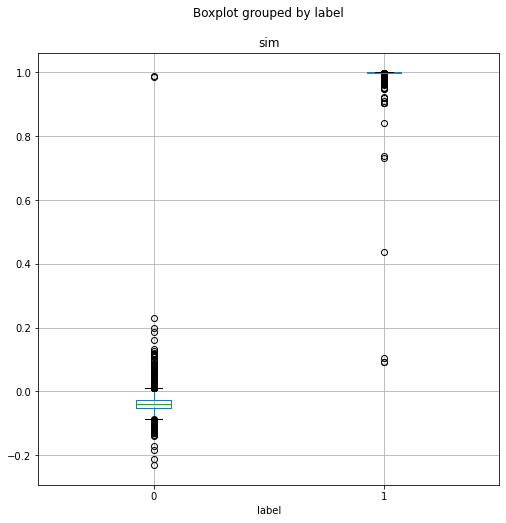

In [24]:
test_df.boxplot(column='sim', by='label', figsize=(8, 8))

<AxesSubplot:xlabel='label', ylabel='sim'>

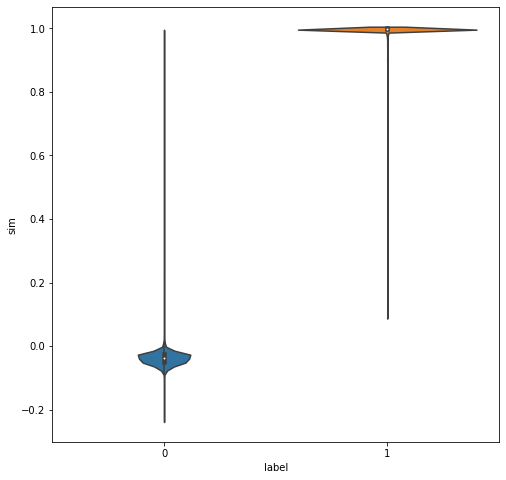

In [30]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.violinplot(ax=ax, x="label", y="sim", data=test_df)

In [31]:
threshold = 0.4
test_df['preds'] = test_df.apply(lambda x: int(x['sim']>=threshold), axis=1)
test_df.head()

,indexA,indexB,label,sim,dist,preds
0,16781,18001,1,0.997752,1917.292847,1
1,161,7203,0,-0.031361,7499.234863,0
2,9072,9064,1,0.999772,3969.956543,1
3,26779,25477,1,0.999592,1861.972290,1
4,5832,4308,0,-0.021486,4637.646484,0


In [34]:
print(confusion_matrix(test_df.label, test_df.preds))

[[9998    2]
 [   3 9997]]


In [35]:
print(classification_report(test_df.label, test_df.preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10000
           1       1.00      1.00      1.00     10000

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000



# Visualizing Embeddings

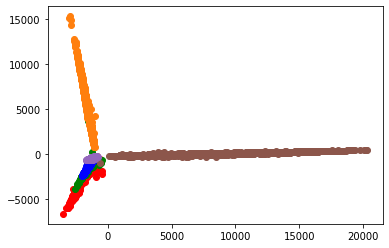

In [38]:
pca = PCA(n_components=2)
pca_results=pca.fit_transform(embeddings)
x=[i[0] for i in pca_results]
y=[i[1] for i in pca_results]
x_andesite=x[:5000]
y_andesite=y[:5000]
x_gneiss=x[5000:10000]
y_gneiss=y[5000:10000]
x_marble=x[10000:14998]
y_marble=y[10000:14998]
x_quartzite=x[14998:19998]
y_quartzite=y[14998:19998]
x_rhyolite=x[19998:24998]
y_rhyolite=y[19998:24998]
x_schist=x[24998:29998]
y_schist=y[24998:29998]
plt.scatter(x_andesite,y_andesite,c="r")
plt.scatter(x_gneiss,y_gneiss,c="g")
plt.scatter(x_marble,y_marble,c="b")
plt.scatter(x_quartzite,y_quartzite,c="#8c564b")
plt.scatter(x_rhyolite,y_rhyolite,c="#9467bd")
plt.scatter(x_schist,y_schist,c="#ff7f0e")
plt.show()

# Testing similarity search

In [42]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
from PIL import Image

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [44]:
with open('best_model.pt', 'rb') as f:
    model = torch.load(f, map_location=device)
model.eval()

SiameseNetwork(
  (cnn1): Sequential(
    (0): ReflectionPad2d((1, 1, 1, 1))
    (1): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1))
    (2): ReLU(inplace=True)
    (3): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout2d(p=0.2, inplace=False)
    (5): ReflectionPad2d((1, 1, 1, 1))
    (6): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU(inplace=True)
    (8): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Dropout2d(p=0.2, inplace=False)
    (10): ReflectionPad2d((1, 1, 1, 1))
    (11): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (12): ReLU(inplace=True)
    (13): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Dropout2d(p=0.2, inplace=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=6272, out_features=500, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=500, out_features=200, bias=True)
    (3): ReLU(inplac

In [51]:
def get_top_k_idx(new_emb, embeddings, k):
    similarities = np.array([(1 - spatial.distance.cosine(new_emb, embeddings[i])) for i in range(len(embeddings))])
    # getting top k indexes in O(n + klogk) instead of sorting the whole list in O(nlogn)
    topk_idx = np.argpartition(similarities, -k)[-k:]
    topk_idx = topk_idx[np.argsort(similarities[topk_idx])[::-1]]
    return topk_idx

In [49]:
def similarity_search(img_path, embeddings, k, model=model, device=device):
    start = time.time()
    img = Image.open(img_path).convert("RGB")
    img = T.ToTensor()(img)
    img = img.unsqueeze(0)  # adds dimension at 0 to represent batch size of 1
    with torch.no_grad():
        img = img.to(device)
        v1, v2 = model(img, img)
    temp_embedding = v1.cpu().detach().numpy()[0]
    topk_idx = get_top_k_idx(temp_embedding, embeddings, k)
    elapsed = time.time() - start
    return topk_idx, elapsed

In [52]:
similarity_search(image_locs['location'][0], embeddings, 10)

(array([   0, 4064, 2854, 3166, 1793, 4700, 2458, 3089, 1666, 4735],
       dtype=int64),
 0.961430549621582)

In [54]:
test_timings = []
testing_images=[]
for i in range(0,100):
    random_index=random.randint(0, len(image_locs)-1)
    testing_images.append(image_locs['location'][random_index])

for i in range(len(testing_images)):
    _, time_taken=similarity_search(image_locs['location'][i], embeddings, 10)
    print(time_taken)
    test_timings.append(time_taken)

print('-'*50)
print("Average time taken:", np.mean(test_timings))

0.9817793369293213
0.9781107902526855
0.9753921031951904
0.9764001369476318
0.9723515510559082
0.9771084785461426
0.9630546569824219
0.9799563884735107
0.9770407676696777
0.9739923477172852
1.002992868423462
0.9571022987365723
0.9778938293457031
0.9730050563812256
0.9680895805358887
0.9625697135925293
0.9783079624176025
0.9800076484680176
0.9576103687286377
0.9737191200256348
0.9836938381195068
0.9779951572418213
0.9647645950317383
0.9793455600738525
0.9798614978790283
0.9710440635681152
0.978644609451294
0.97491455078125
0.9473931789398193
1.0243847370147705
1.0362293720245361
1.065669298171997
1.0572466850280762
1.0666534900665283
1.020087718963623
1.028648853302002
1.0332393646240234
1.0468385219573975
1.12125563621521
1.0163426399230957
0.9823758602142334
0.9660303592681885
0.979189395904541
0.9728407859802246
0.9810068607330322
0.9624271392822266
0.9634582996368408
0.9733977317810059
0.9755852222442627
0.9823713302612305
0.9664111137390137
0.9675073623657227
0.9733967781066895
0.9